# How to Fine-Tune Multimodal Models or VLMs with Hugging Face TRL

FROM https://github.com/philschmid/deep-learning-pytorch-huggingface/blob/main/training/fine-tune-multimodal-llms-with-trl.ipynb

SEE VIDEO https://www.youtube.com/watch?v=zGqQGtmXFQ8

Multimodal LLMs are making tremendous progress recently. We now have a diverse ecosystem of powerful open Multimodal models, mostly Vision-Language Models (VLM), including Meta AI's [Llama-3.2-11B-Vision](https://huggingface.co/meta-llama/Llama-3.2-11B-Vision-Instruct), Mistral AI's [Pixtral-12B](https://huggingface.co/mistralai/Pixtral-12B-2409), Qwen's [Qwen2-VL-7B](https://huggingface.co/Qwen/Qwen2-VL-7B), and Allen AI's [Molmo-7B-D-0924](https://huggingface.co/allenai/Molmo-7B-D-0924).

These VLMs can handle a variety of multimodal tasks, including image captioning, visual question answering, and image-text matching without additional training. However, to customize a model for your specific application, you may need to fine-tune it on your data to achieve higher quality results or to create a more efficient model for your use case.

This blog post walks you through how to fine-tune open VLMs using Hugging Face [TRL](https://huggingface.co/docs/trl/index), [Transformers](https://huggingface.co/docs/transformers/index) & [datasets](https://huggingface.co/docs/datasets/index) in 2024. We'll cover:

1. Define our multimodal use case
1. Setup development environment
2. Create and prepare the multimodal dataset
3. Fine-tune VLM using `trl` and the `SFTTrainer`
4. Test and evaluate the VLM

_Note: This blog was created to run on consumer size GPUs (24GB), e.g. NVIDIA A10G or RTX 4090/3090, but can be easily adapted to run on bigger GPUs._

#STEP 1 (conceptual). Define our multimodal use case

When fine-tuning VLMs, it's crucial to clearly define your use case and the multimodal task you want to solve. This will guide your choice of base model and help you create an appropriate dataset for fine-tuning. If you haven't defined your use case yet, you might want to revisit your requirements.

It's worth noting that for most use cases fine-tuning might not be the first option. We recommend evaluating pre-trained models or API-based solutions before committing to fine-tuning your own model.

As an example, we'll use the following multimodal use case:

> We want to fine-tune a model that can generate detailed product descriptions based on product images and basic metadata. This model will be integrated into our e-commerce platform to help sellers create more compelling listings. The goal is to reduce the time it takes to create product descriptions and improve their quality and consistency.

Existing models might already be very good for this use case, but you might want to tweak/tune it to your specific needs. This image-to-text generation task is well-suited for fine-tuning VLMs, as it requires understanding visual features and combining them with textual information to produce coherent and relevant descriptions. I created a test dataset for this use case using Gemini 1.5 [philschmid/amazon-product-descriptions-vlm](https://huggingface.co/datasets/philschmid/amazon-product-descriptions-vlm).

#STEP 2. Setup development environment

Our first step is to install Hugging Face Libraries and Pyroch, including trl, transformers and datasets. If you haven't heard of trl yet, don't worry. It is a library on top of transformers and datasets, which makes it easier to fine-tune, rlhf, align open LLMs.


In [1]:
# Install Pytorch & other libraries
%pip install "torch==2.4.0" tensorboard pillow

# Install Hugging Face libraries
%pip install  --upgrade \
  "transformers==4.45.1" \
  "datasets==3.0.1" \
  "accelerate==0.34.2" \
  "evaluate==0.4.3" \
  "bitsandbytes==0.44.0" \
  "trl==0.11.1" \
  "peft==0.13.0" \
  "qwen-vl-utils"

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/spinners.py", line 9, in <module>
    from pip._internal.utils.logging import get_indentation
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/utils/logging.py", line 13, in <module>
    from pip._vendor.rich.

We will use the [Hugging Face Hub](https://huggingface.co/models) as a remote model versioning service. This means we will automatically push our model, logs and information to the Hub during training. You must register on the [Hugging Face](https://huggingface.co/join) for this. After you have an account, we will use the `login` util from the `huggingface_hub` package to log into our account and store our token (access key) on the disk.


## Process
#### Step 1: Go to your Hugging Face account & log in


* In the top-right corner, click your profile picture → Settings

#### Step 2: Create an access token

* In the left menu, click Access Tokens.

* Click New token.

* Give it a name (e.g., “training-script”) and select Write scope (so you can push models).

* Click Generate token & copy it

#### Step 3: Add your token to Colab secrets

* In your Colab notebook, go to the menu:
Tools → Settings → Variables (sometimes called “Secrets” or “Environment”).

* Add a new variable: Name: HuggingFaceToken  & Value: your Hugging Face access token (e.g., hf_xxxxxxx...).

* Save it.



In [ ]:
import os
from google.colab import userdata


token = userdata.get('HuggingFaceToken')
print(token)

In [3]:
import os
from huggingface_hub import login

login(token=token, add_to_git_credential=True)


# STEP 3. Create and prepare the dataset

Once you have determined that fine-tuning is the right solution we need to create a dataset to fine-tune our model. We have to prepare the dataset in a format that the model can understand.

In our example we will use [philschmid/amazon-product-descriptions-vlm](https://huggingface.co/datasets/philschmid/amazon-product-descriptions-vlm), which contains **1,350** amazon products with title, images and descriptions and metadata. We want to fine-tune our model to generate product descriptions based on the images, title and metadata. Therefore we need to create a prompt including the title, metadata and image and the completion is the description.

TRL supports popular instruction and conversation dataset formats. This means we only need to convert our dataset to one of the supported formats and `trl` will take care of the rest.
```json
"messages": [
  {"role": "system", "content": [{"type":"text", "text": "You are a helpful...."}]},
  {"role": "user", "content": [{
    "type": "text", "text":  "How many dogs are in the image?",
    "type": "image", "text": <PIL.Image>
    }]},
  {"role": "assistant", "content": [{"type":"text", "text": "There are 3 dogs in the image."}]}
],
```


In our example we are going to load our dataset using the Datasets library (datasets here is the [🤗 Hugging Face Datasets library](https://huggingface.co/docs/datasets?utm_source=chatgpt.com)) and apply our frompt and convert it into the the conversational format.

Lets start with defining our instruction prompt.


### Dataset ([philschmid/amazon-product-descriptions-vlm](https://huggingface.co/datasets/philschmid/amazon-product-descriptions-vlm)) is a vision-language dataset.


Containing:

[image, Uniq Id, Product Name, Category, Selling Price, Model Number, About Product, Product, Technical Details, Shipping Weight, Variants, Product Url, Is Amazon Seller, description]
* images are of varying sizes



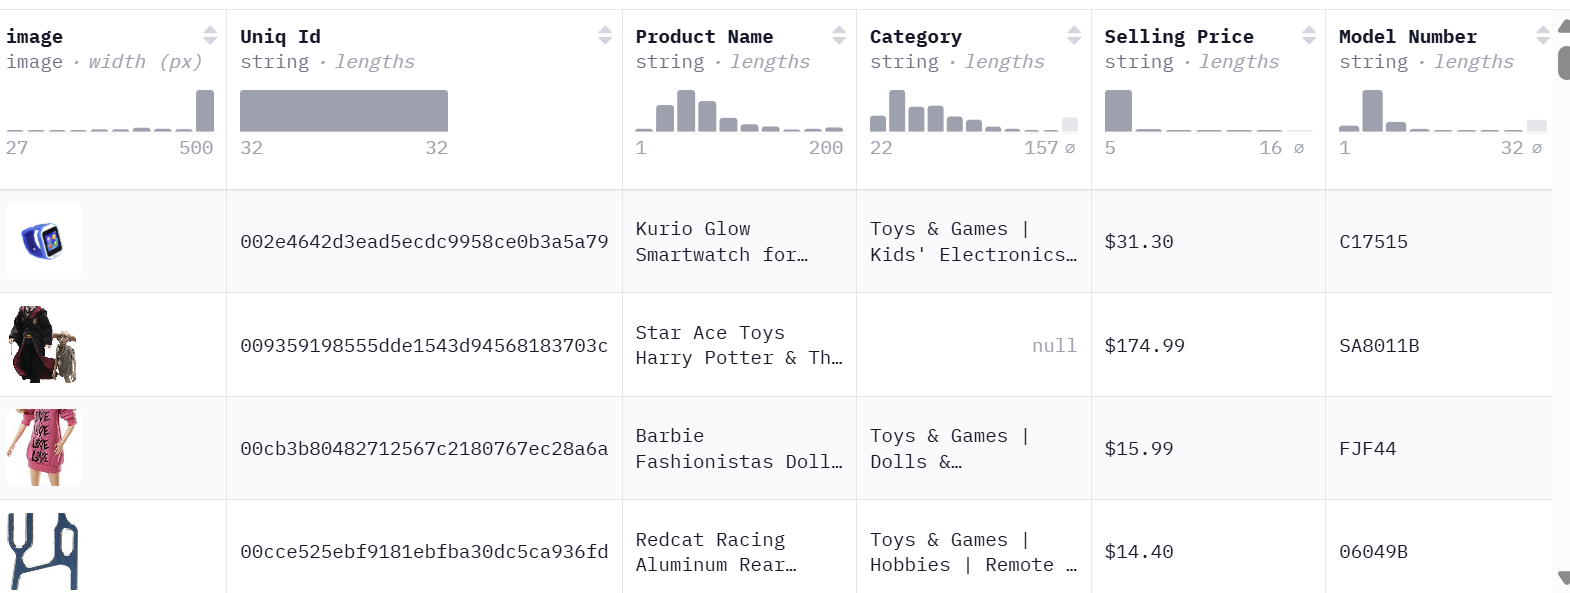

## Create Prompt - image not part of prompt but, included as part of processor

**How images are loaded**

When you access a sample:



```
sample = dataset_hf[345]
img = sample["image"]
print(type(img))
```





you’ll get:
```
<class 'PIL.Image.Image'>
```

That’s because the Datasets library detects the "image" feature type and decodes it into a PIL object transparently.

⚡ Important:

* The actual bytes of the image are still cached on disk under the Hugging Face cache directory.

* Only when you index into the dataset does it decode into a PIL image in memory.



In [4]:
# note the image is not provided in the prompt its included as part of the "processor"
prompt= """Create a Short Product description based on the provided ##PRODUCT NAME## and ##CATEGORY## and image.
Only return description. The description should be SEO optimized and for a better mobile search experience.

##PRODUCT NAME##: {product_name}
##CATEGORY##: {category}"""

system_message = "You are an expert product description writer for Amazon."

Now, we can format our dataset.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset Column Names
['image', 'Uniq Id', 'Product Name', 'Category', 'Selling Price', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Variants', 'Product Url', 'Is Amazon Seller', 'description']


 Sample 345
[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an expert product description writer for Amazon.'}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'Create a Short Product description based on the provided ##PRODUCT NAME## and ##CATEGORY## and image.\nOnly return description. The description should be SEO optimized and for a better mobile search experience.\n\n##PRODUCT NAME##: MasterPieces Tribal Spirit Jigsaw Puzzle, The Chiefs, Featuring American Indian Tribe Traditions & Ceremonies, 1000 Pieces\n##CATEGORY##: Toys & Games | Puzzles | Jigsaw Puzzles'}, {'type': 'image', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7A901BD99B20>}]}, {'role': 'assistant', 'content': [{'ty

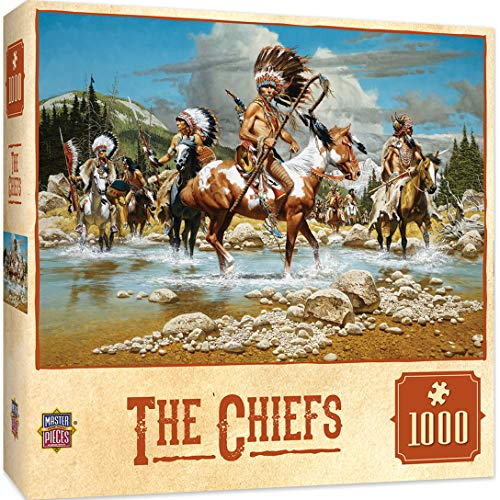

In [5]:
from datasets import load_dataset

# Convert dataset to OAI messages
def format_data(sample):
    return {"messages": [
                {
                    "role": "system",
                    "content": [{"type": "text", "text": system_message}],
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt.format(product_name=sample["Product Name"], category=sample["Category"]),
                        },{
                            "type": "image",
                            "image": sample["image"],
                        }
                    ],
                },
                {
                    "role": "assistant",
                    "content": [{"type": "text", "text": sample["description"]}],
                },
            ],
        }

# Load dataset from the hub
dataset_id = "philschmid/amazon-product-descriptions-vlm"
dataset_hf = load_dataset("philschmid/amazon-product-descriptions-vlm", split="train")

# Convert dataset to OAI messages
# need to use list comprehension to keep Pil.Image type, .mape convert image to bytes
dataset = [format_data(sample) for sample in dataset_hf]

print("Dataset Column Names")
print(dataset_hf.column_names)

print("\n\n Sample 345")

#print out message for arbitrary same #345 in dataset
print(dataset[345]["messages"])

#use Hugging Face dataset to see image
from IPython.display import display
img = dataset_hf[345]["image"]
print(type(img))
display(img)

# STEP 4. SETUP Fine-tune VLM using `trl` and the `SFTTrainer`

We are now ready to fine-tune our model. We will use the [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer) from `trl` to fine-tune our model. The `SFTTrainer` makes it straightfoward to supervise fine-tune open LLMs and VLMs. The `SFTTrainer` is a subclass of the `Trainer` from the `transformers` library and supports all the same features, including logging, evaluation, and checkpointing, but adds additiional quality of life features.

We will use the PEFT features in our example. As peft method we will use [QLoRA](https://arxiv.org/abs/2305.14314) a technique to reduce the memory footprint of large language models during finetuning, without sacrificing performance by using quantization. If you want to learn more about QLoRA and how it works, check out [Making LLMs even more accessible with bitsandbytes, 4-bit quantization and QLoRA](https://huggingface.co/blog/4bit-transformers-bitsandbytes) blog post.


_Note: We cannot use Flash Attention as we need to pad our multimodal inputs._

We are going to use Qwen 2 VL 7B model, but we can easily swap out the model for another model, including Meta AI's [Llama-3.2-11B-Vision](https://huggingface.co/meta-llama/Llama-3.2-11B-Vision-Instruct), Mistral AI's [Pixtral-12B](https://huggingface.co/mistralai/Pixtral-12B-2409) or any other LLMs by changing our `model_id` variable. We will use bitsandbytes to quantize our model to 4-bit.

_Note: Be aware the bigger the model the more memory it will require. In our example we will use the 7B version, which can be tuned on 24GB GPUs._

Correctly, preparing the LLM, Tokenizer and Processor for training VLMs is crucial. The Processor is responsible for including the special tokens and image features in the input.

## STEP 4.1 Install torch torchvision version

In [6]:
!pip -q install --upgrade --force-reinstall \
  "torch==2.4.0" "torchvision==0.19.0" "torchaudio==2.4.0" \
  --index-url https://download.pytorch.org/whl/cu121


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
tyro 0.9.31 requires typing-extensions>=4.13.0, but you have typing-extensions 4.12.2 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.
typeguard 4.4.4 requires typing_extensions>=4.14.0, but you have typing-extensions 4.12.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.2 which is incompatible.
pytensor 2.31.7 requires filelock>=3.15, but you have filelock 3.13.1 which is incompatible.


In [7]:
%pip -q install -U "transformers>=4.44.2" "accelerate>=0.34.2" "bitsandbytes>=0.44.1" peft trl timm pillow


## Import modules

In [8]:
import torch, importlib, torchvision, sys
print("torch:", torch.__version__, "cuda:", torch.version.cuda)
print("torchvision:", torchvision.__version__)
print("python:", sys.version)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

try:
    import bitsandbytes as bnb
    print("bitsandbytes version:", bnb.__version__)
except Exception as e:
    print("bitsandbytes import failed:", e)


'''
!pip -q install -U "transformers>=4.44" "accelerate>=0.34" "bitsandbytes>=0.44" timm pillow

'''

torch: 2.4.0+cu121 cuda: 12.1
torchvision: 0.19.0+cu121
python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
CUDA available: True
GPU: Tesla T4
bitsandbytes version: 0.47.0


'\n!pip -q install -U "transformers>=4.44" "accelerate>=0.34" "bitsandbytes>=0.44" timm pillow\n\n'

## STEP 4.3 Setup Model using AutoModeForVision2Seq.from_pretrained() associated with model_id ([Qwen2-VL-7B-Instruct](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct))


###NOTE: if you want to play with this model prior to fine-tuning check it out at [Hugging Face's Playground](https://huggingface.co/playground?modelId=Qwen/Qwen2-VL-7B-Instruct&provider=hyperbolic) --you will need to copy and paste your token there to run it.

**CODE STEPS**

1.  **AutoModelForVision2Seq**: loads a vision-language model that can read images + text and generate text.

2.   **AutoProcesso**r: loads the combined tokenizer + image preprocessor + chat template that matches the model.

3.   **BitsAndBytesConfig:** config for 4-bit quantization via bitsandbytes to save VRAM.
* load_in_4bit=True: load most weights in 4-bit (major memory reduction).

* bnb_4bit_use_double_quant=True: a second quantization pass on the quantization constants (saves a bit more memory).

*  bnb_4bit_quant_type="nf4": use NF4 (normal-float-4), a better 4-bit quantizer than plain int4.

*  bnb_4bit_compute_dtype=torch.bfloat16: during matmul, dequantize to bf16 for compute (not int4 math!). ✅ Good on A100/L4/H100. ⚠️ On T4 GPUs, bf16 is not supported — use torch.float16 instead or it’ll error/slow down.

*  Requires bitsandbytes and a CUDA GPU.

4.   **AutoModelForVision2Seq.from_pretrained():**
* device_map="auto": lets Accelerate decide where to put layers (GPU / multiple GPUs).

* torch_dtype=torch.bfloat16: set the model’s compute dtype (again, on T4 you should use torch.float16).

* ( quantization_config=bnb_config: activates 4-bit loading with your settings above.

* (Optional) attn_implementation="flash_attention_2" is commented because some training paths don’t support it.


5. **AutoProcessor.from_pretrained(model_id)**
* Pulls the tokenizer, image processor (resize/normalize), and chat template for Qwen2-VL.

* You’ll use it like:
```
processor.apply_chat_template(messages, ...) to make the prompt string.

processor(text=[...], images=[...], return_tensors="pt") to get tensors for model.generate(...).
```



In [9]:
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig

# Hugging Face model id
model_id = "Qwen/Qwen2-VL-7B-Instruct"

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map="auto",
    # attn_implementation="flash_attention_2", # not supported for training
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
processor = AutoProcessor.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

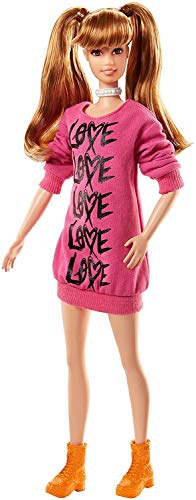



 OUTPUT
<|im_start|>system
You are an expert product description writer for Amazon.<|im_end|>
<|im_start|>user
Create a Short Product description based on the provided ##PRODUCT NAME## and ##CATEGORY## and image.
Only return description. The description should be SEO optimized and for a better mobile search experience.

##PRODUCT NAME##: Barbie Fashionistas Doll Wear Your Heart
##CATEGORY##: Toys & Games | Dolls & Accessories | Dolls<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant
Express your style with Barbie Fashionistas Doll Wear Your Heart! This fashionable doll boasts a unique outfit and accessories, perfect for imaginative play.  A great gift for kids aged 3+.  Collect them all! #Barbie #Fashionistas #Doll #Toys #GirlsToys #FashionDoll #Play<|im_end|>



In [10]:
# Preparation of message for training
text = processor.apply_chat_template(
    dataset[2]["messages"], tokenize=False, add_generation_prompt=False
)

img = dataset_hf[2]["image"]
display(img)
print("\n\n OUTPUT")
print(text)

# STEP 5. Config for Training : Fine-tune VLM using `trl` and the `SFTTrainer`
* first setup Configuration for training.

The `SFTTrainer`  supports a native integration with `peft`, which makes it super easy to efficiently tune LLMs using, e.g. QLoRA. We only need to create our `LoraConfig` and provide it to the trainer. Our `LoraConfig` parameters are defined based on the [qlora paper](https://arxiv.org/pdf/2305.14314.pdf) and sebastian's [blog post](https://magazine.sebastianraschka.com/p/practical-tips-for-finetuning-llms).

In [11]:
from peft import LoraConfig

# LoRA config based on QLoRA paper & Sebastian Raschka experiment
peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.05,
        r=8,
        bias="none",
        target_modules=["q_proj", "v_proj"],
        task_type="CAUSAL_LM",
)

Before we can start our training we need to define the hyperparameters (`SFTConfig`) we want to use and make sure our inputs are correcty provided to the model. Different to text-only supervised fine-tuning we need to provide the image to the model as well. Therefore we create a custom `DataCollator` which formates the inputs correctly and include the image features. We use the [process_vision_info](https://github.com/QwenLM/Qwen2-VL/blob/main/qwen-vl-utils/src/qwen_vl_utils/vision_process.py#L321) method from a utility package the Qwen2 team provides. If you are using another model, e.g. Llama 3.2 Vision you might have to check if that creates the same processsed image information.

In [13]:
# Mount Drive (once per session)
from google.colab import drive
drive.mount("/content/drive")

import os, time

# Choose a folder in Drive and make a unique run folder
root_dir = "/content/drive/MyDrive/iLab/Orientation/FineTuneQwenMultiModal/vlm_runs"   # change if you like
run_name = f"qwen2vl_2b_amazon_desc_{time.strftime('%Y-%m-%d_%H-%M-%S')}"
save_dir = os.path.join(root_dir, run_name)

print(save_dir)
os.makedirs(save_dir, exist_ok=True)           # <- creates the directory if missing
%ls -las {save_dir}
%ls -las {root_dir}



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/iLab/Orientation/FineTuneQwenMultiModal/vlm_runs/qwen2vl_2b_amazon_desc_2025-09-05_01-15-27
total 0
total 12
4 drwx------ 4 root root 4096 Sep  4 04:07 qwen2vl_2b_amazon_desc_2025-09-04_04-07-25/
4 drwx------ 2 root root 4096 Sep  5 01:05 qwen2vl_2b_amazon_desc_2025-09-05_01-05-01/
4 drwx------ 2 root root 4096 Sep  5 01:15 qwen2vl_2b_amazon_desc_2025-09-05_01-15-27/


In Hugging Face/TRL terms, **one “step” = one optimizer update** (after gradient accumulation).
The number of samples that flow through the model per step is:

**samples\_per\_step = per\_device\_train\_batch\_size × gradient\_accumulation\_steps × world\_size**

**steps_per_epoch = ceil( N / (per_device_train_batch_size * gradient_accumulation_steps * world_size) )**

* `N` = number of training samples
* `world_size` = number of GPUs (processes) doing **data parallel** training.
* With the config (`per_device_train_batch_size=4`, `gradient_accumulation_steps=8`) and **one GPU**, that’s **4 × 8 × 1 = 32 samples per step**.
* If you were using 2 GPUs with data parallel, it’d be **4 × 8 × 2 = 64**.

Notes:

* The **last step** of an epoch may have fewer samples if the dataset size isn’t divisible.
* Model parallelism (`device_map="auto"`) doesn’t change `world_size`; on Colab you’re typically at `world_size=1`.


NOTE:
world_size = the total number of parallel training processes (usually the number of GPUs doing data-parallel training across all machines).

Single-GPU / Colab: world_size = 1

Multi-GPU on one node (DDP): world_size = #GPUs

Multi-node: world_size = #GPUs per node × #nodes


### <font color=red> max_steps takes precedence over num_train_epochs </font>

* if `max_steps < steps_per_epoch*num_train_epochs` it means you will only train max_steps

* if `max_steps > steps_per_epoch*num_train_epochs` it will STILL keep looping until `max_steps` is executed

In [ ]:
from trl import SFTConfig
from transformers import Qwen2VLProcessor
from qwen_vl_utils import process_vision_info

num_train_epochs = 1
max_steps = 5 #NOT much training AT all much less than 1 epoch...partial data

args = SFTConfig(
    # output_dir="qwen2-7b-instruct-amazon-description", # directory to save and repository id
    output_dir=save_dir, # directory to save and repository id
    num_train_epochs=num_train_epochs,                     # number of training epochs
    max_steps= max_steps,                           # **** train for 5 update steps (< 1 epoch)
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_accumulation_steps=8,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=5,                       # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    bf16=True,                              # use bfloat16 precision
    tf32=False,                              # use tf32 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=True,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    gradient_checkpointing_kwargs = {"use_reentrant": False}, # use reentrant checkpointing
    dataset_text_field="", # need a dummy field for collator
    dataset_kwargs = {"skip_prepare_dataset": True} # important for collator
)
args.remove_unused_columns=False

# Create a data collator to encode text and image pairs
def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [processor.apply_chat_template(example["messages"], tokenize=False) for example in examples]
    image_inputs = [process_vision_info(example["messages"])[0] for example in examples]

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  #
    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2VLProcessor):
        image_tokens = [151652,151653,151655]
    else:
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100
    batch["labels"] = labels

    return batch

We now have every building block we need to create our `SFTTrainer` to start then training our model.

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


# STEP 6. Train & Save model



Start training our model by calling the `train()` method on our `Trainer` instance. This will start the training loop and train our model (see arguments above). Since we are using a PEFT method, we will only save the adapted model weights and not the full model.



when training you should see results like the following.   It takes a while to even get through 1 epoch of data (below screenshot shows wall clock time of almost 4 hours --not the same as the actual shared resource GPU processing time).

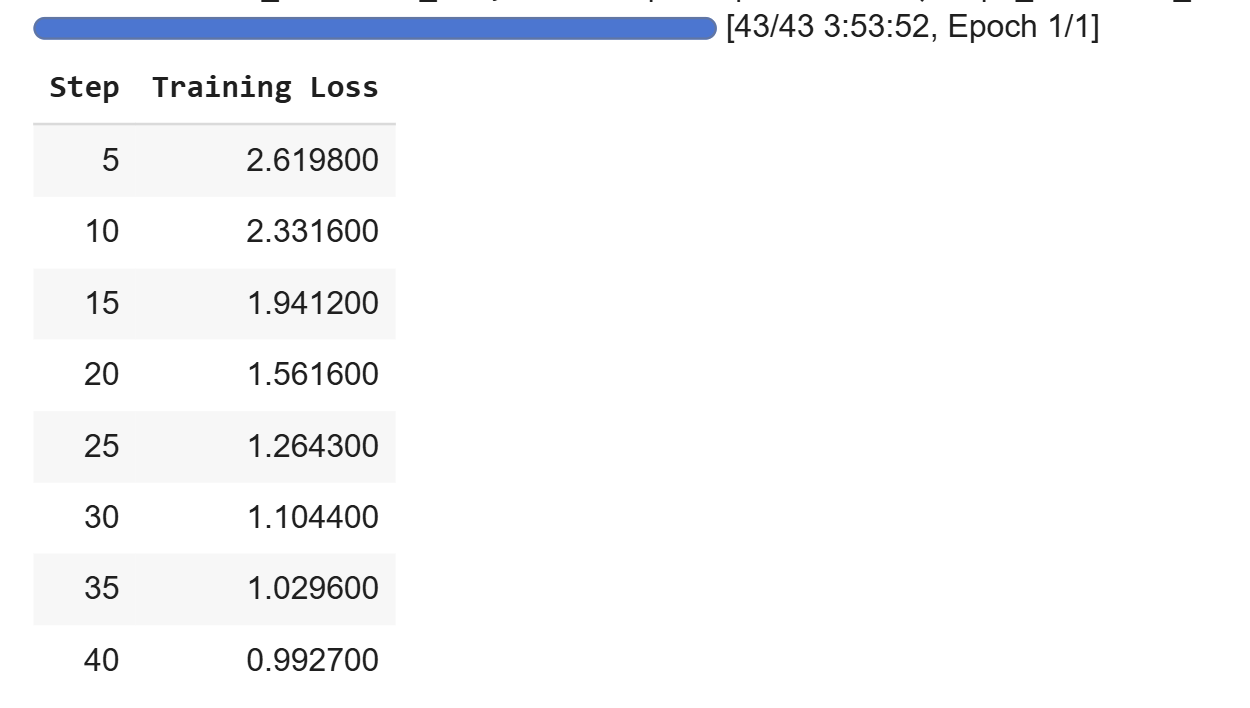

In [ ]:
# start training, the model will be automatically saved to the hub and the output directory
trainer.train()

# save model
# Save LoRA adapter + processor here
trainer.save_model(args.output_dir)  # saves PEFT adapter weights/config
processor.save_pretrained(args.output_dir)            # saves tokenizer + image processor

print("Saved to:", save_dir)



/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


Step,Training Loss
5,2.619800
10,2.331600
15,1.941200
20,1.561600
25,1.264300
30,1.104400
35,1.029600
40,0.992700


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...25-09-04_04-07-25/training_args.bin: 100%|##########| 6.01kB / 6.01kB            

  ...ents.1756959092.bf5fca2a2722.4902.0: 100%|##########| 8.58kB / 8.58kB            

  ...ents.1756959615.bf5fca2a2722.4902.1: 100%|##########| 12.1kB / 12.1kB            

  ..._04-07-25/adapter_model.safetensors: 100%|##########| 10.1MB / 10.1MB            

  ..._2025-09-04_04-07-25/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Saved to: /content/drive/MyDrive/iLab/Orientation/FineTuneQwenMultiModal/vlm_runs/qwen2vl_2b_amazon_desc_2025-09-04_04-07-25


In [ ]:
import os, glob
print("Saved to:", args.output_dir)
print("\nAdapter files:", glob.glob(os.path.join(args.output_dir, "adapter*.*")))
print("Processor files:", [p for p in os.listdir(args.output_dir) if "tokenizer" in p or "processor" in p or "image" in p or "generation" in p or p.endswith(".json")])


Saved to: /content/drive/MyDrive/iLab/Orientation/FineTuneQwenMultiModal/vlm_runs/qwen2vl_2b_amazon_desc_2025-09-04_04-07-25

Adapter files: ['/content/drive/MyDrive/iLab/Orientation/FineTuneQwenMultiModal/vlm_runs/qwen2vl_2b_amazon_desc_2025-09-04_04-07-25/adapter_config.json', '/content/drive/MyDrive/iLab/Orientation/FineTuneQwenMultiModal/vlm_runs/qwen2vl_2b_amazon_desc_2025-09-04_04-07-25/adapter_model.safetensors']
Processor files: ['adapter_config.json', 'preprocessor_config.json', 'tokenizer_config.json', 'special_tokens_map.json', 'added_tokens.json', 'vocab.json', 'tokenizer.json', 'video_preprocessor_config.json']


IF Training for 3 epochs with a dataset of ~1k samples took 01:31:58 on a `g6.2xlarge`. The instance costs `0.9776$/h` which brings us to a total cost of only `1.4$`.

## STEP 6.1:  DO a quick inference after saving.

In [ ]:
# === Quick inference right after training ===
import torch
from PIL import Image

# Use the model already trained in memory
model_for_infer = trainer.model
model_for_infer.eval()
# For training we disabled cache; re-enable for faster generation
if hasattr(model_for_infer, "config"):
    model_for_infer.config.use_cache = True

# Make sure generation uses the same special tokens as the tokenizer
if hasattr(model_for_infer, "generation_config"):
    model_for_infer.generation_config.pad_token_id = processor.tokenizer.pad_token_id
    model_for_infer.generation_config.bos_token_id = processor.tokenizer.bos_token_id
    model_for_infer.generation_config.eos_token_id = processor.tokenizer.eos_token_id

def generate_once(image, user_text, max_new_tokens=128, temperature=0.2):
    # Build chat-style message with image + text
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": user_text},
        ]}
    ]
    prompt = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # Encode inputs and move to the model's device
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(model_for_infer.device) for k, v in inputs.items()}

    with torch.inference_mode():
        out = model_for_infer.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=(temperature is not None and temperature > 0),
            temperature=temperature,
        )
    return processor.tokenizer.decode(out[0], skip_special_tokens=True)

# --- Choose a test image ---
# Option A: use an image from your dataset if available
test_img = None
try:
    # adapt these names to your dataset variable(s)
    test_img = dataset_hf[2]["image"]
except Exception:
    # Option B: load from path
    test_img = Image.open(root_dir = "/content/drive/MyDrive/iLab/Orientation/FineTuneQwenMultiModal/maxmaraskirt.jpg").convert("RGB")  # <-- change

# Run a sample prompt
display(test_img)
user_text = "Write a concise, mobile-friendly Amazon product description."
prediction = generate_once(test_img, user_text, max_new_tokens=128, temperature=0.2)
print("\n=== Fine-tuned model output ===\n", prediction)


SyntaxError: unterminated string literal (detected at line 49) (ipython-input-4194198605.py, line 49)

In [ ]:
# free the memory again
del model
del trainer
torch.cuda.empty_cache()

# STEP 7. Load Saved Model & Test Model and run Inference & compare to original (before fine-tuning) model

After the training is done we want to evaluate and test our model. First we will load the base model and let it generate a description for a random Amazon product. Then we will load our Q-LoRA adapted model and let it generate a description for the same product.

Finally we can merge the adapter into the base model to make it more efficient and run inference on the same product again.

## STEP 7.1 Load Base Model & run inference

In [2]:
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq

adapter_path = save_dir #"./qwen2-7b-instruct-amazon-description"

# Load Model base model
model = AutoModelForVision2Seq.from_pretrained(
  model_id,
  device_map="auto",
  torch_dtype=torch.float16
)
processor = AutoProcessor.from_pretrained(model_id)

NameError: name 'save_dir' is not defined

I selected a random product from Amazon and prepared a `generate_description` function to generate a description for the product.

In [15]:
# sample from amazon.com
sample = {
  "product_name": "Hasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur",
  "catergory": "Toys & Games | Toy Figures & Playsets | Action Figures",
  "image": "https://m.media-amazon.com/images/I/81+7Up7IWyL._AC_SY300_SX300_.jpg"
}

# prepare message
messages = [{
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": sample["image"],
            },
            {"type": "text", "text": prompt.format(product_name=sample["product_name"], category=sample["catergory"])},
        ],
    }
]

print(sample)

{'product_name': 'Hasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur', 'catergory': 'Toys & Games | Toy Figures & Playsets | Action Figures', 'image': 'https://m.media-amazon.com/images/I/81+7Up7IWyL._AC_SY300_SX300_.jpg'}


In [16]:
print(processor)

Qwen2VLProcessor:
- image_processor: Qwen2VLImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": true,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": null,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "Qwen2VLImageProcessorFast",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "input_data_format": null,
  "max_pixels": 12845056,
  "merge_size": 2,
  "min_pixels": 3136,
  "patch_size": 14,
  "processor_class": "Qwen2VLProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "return_tensors": null,
  "size": {
    "longest_edge": 12845056,
    "shortest_edge": 3136
  },
  "temporal_patch_size": 2
}

- tokenizer: Qwen2TokenizerFast(name_or_path='Qwen/Qwen2-VL-7B-Instruct', vocab_size=151643, model_max_length=32768, is_fast=True, padding_side='lef

In [22]:
# If needed: !pip -q install ipywidgets
import ipywidgets as widgets
from IPython.display import display
import torch
from qwen_vl_utils import process_vision_info


from transformers.utils import logging
logging.set_verbosity_info()   # or set TRANSFORMERS_VERBOSITY=info env var
output_result = None  # global holder


# Widgets
mode_dd = widgets.Dropdown(options=["Normal", "Faster"], value="Faster", description="Inference:")
run_btn = widgets.Button(description="Generate")
out = widgets.Output()

def generate_description(sample, model, processor, inference_mode="Normal"):
    messages = [
        {"role": "system", "content": [{"type": "text", "text": system_message}]},
        {"role": "user", "content": [
            {"type": "image","image": sample["image"]},
            {"type": "text", "text": prompt.format(
                product_name=sample.get("product_name",""),
                category=sample.get("category", sample.get("catergory",""))
            )},
        ]},
    ]
    print("messages"); print(messages)

    # Prep
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(text=[text], images=image_inputs, videos=video_inputs,
                       padding=True, return_tensors="pt")
    print("inputs"); print(inputs)
    print(type(image_inputs[0]))
    display(image_inputs[0])  # will render inside `out`

    inputs = inputs.to(model.device)

    # Gen args
    if (inference_mode or "").lower().startswith("normal"):
        print("Using Normal mode: sampling (max_new_tokens=256, top_p=1.0, temperature=0.8)")
        gen_kwargs = dict(max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8)
    else:
        print("Using Faster mode: greedy (max_new_tokens=64, min_new_tokens=8)")
        gen_kwargs = dict(max_new_tokens=64, min_new_tokens=8, do_sample=False)

    with torch.inference_mode():
        generated_ids = model.generate(**inputs, **gen_kwargs)

    print("Generated_ids shape:", tuple(generated_ids.shape))
    gen_trim = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    text_out = processor.batch_decode(gen_trim, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    print("TEXT_OUT IS")
    print(text_out)
    return (text_out[0].strip() if text_out else "")

def _on_click(_):
    global output_result
    # IMPORTANT: clear the widget's output, not the cell's
    out.clear_output(wait=True)
    with out:
        try:
            print(f"Selected mode: {mode_dd.value}")
            output_result = generate_description(sample, model, processor, inference_mode=mode_dd.value)
            print("\n--- Output ---")
            print(output_result if output_result else "[No text generated]")
        except Exception as e:
            import traceback
            print("Error during generation:", repr(e))
            traceback.print_exc()

print("Will Ask if Fast or Normal Inference")
# Display UI and bind handler
ui = widgets.HBox([mode_dd, run_btn])
display(ui, out)

# Rebind (safe to call multiple times; recreating the button also resets handlers)
run_btn.on_click(_on_click)


Will Ask if Fast or Normal Inference


Output()

## STEP 7.2 Load Saved_Model & run inference
Lets load our adapter and compare if with the base model.

In [25]:
# Mount Drive (once per session)
from google.colab import drive
drive.mount("/content/drive")

import os, subprocess
from IPython.display import display, clear_output
import ipywidgets as widgets

# Your runs folder
root_dir = "/content/drive/MyDrive/iLab/Orientation/FineTuneQwenMultiModal/vlm_runs"

# Sanity check
if not os.path.isdir(root_dir):
    raise FileNotFoundError(f"Root folder not found: {root_dir}")

# Collect existing run directories (no 'create new')
dirs = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

if not dirs:
    print(f"No run folders found in:\n  {root_dir}\nCreate one first, then re-run this cell.")
else:
    dd = widgets.Dropdown(
        options=dirs,
        description="Run:",
        layout=widgets.Layout(width="70%"),
    )
    btn = widgets.Button(description="Confirm", button_style="primary")
    out = widgets.Output()

    def on_click(_):
        with out:
            clear_output()
            run_name = dd.value
            save_dir = os.path.join(root_dir, run_name)
            # expose for later cells
            globals()["save_dir"] = save_dir
            # if you have args, keep it in sync (safe to ignore if args doesn't exist)
            try:
                args.output_dir = save_dir
            except NameError:
                pass

            print("save_dir:", save_dir, "\n\nContents:")
            subprocess.run(["ls", "-las", save_dir])

    btn.on_click(on_click)
    display(dd, btn, out)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dropdown(description='Run:', layout=Layout(width='70%'), options=('qwen2vl_2b_amazon_desc_2025-09-04_04-07-25'…

Button(button_style='primary', description='Confirm', style=ButtonStyle())

Output()

In [26]:
%ls -las {save_dir}

total 25396
    1 -rw------- 1 root root      859 Sep  4 08:19 adapter_config.json
 9873 -rw------- 1 root root 10108960 Sep  4 08:19 adapter_model.safetensors
    1 -rw------- 1 root root      392 Sep  4 08:19 added_tokens.json
    1 -rw------- 1 root root     1017 Sep  4 08:19 chat_template.jinja
    4 drwx------ 2 root root     4096 Sep  4 08:19 checkpoint-43/
 1633 -rw------- 1 root root  1671853 Sep  4 08:19 merges.txt
    1 -rw------- 1 root root      788 Sep  4 08:19 preprocessor_config.json
    2 -rw------- 1 root root     1551 Sep  4 08:19 README.md
    4 drwx------ 2 root root     4096 Sep  4 04:11 runs/
    1 -rw------- 1 root root      613 Sep  4 08:19 special_tokens_map.json
    4 -rw------- 1 root root     3281 Sep  4 08:19 tokenizer_config.json
11153 -rw------- 1 root root 11420538 Sep  4 08:19 tokenizer.json
    6 -rw------- 1 root root     6008 Sep  4 08:19 training_args.bin
    1 -rw------- 1 root root      932 Sep  4 08:19 video_preprocessor_config.json
 2712 -rw----

#redefine slightly the generate_description function to work with saved model that will be loaded below

In [33]:
# If needed: !pip -q install ipywidgets
import ipywidgets as widgets
from IPython.display import display
import torch
from qwen_vl_utils import process_vision_info


from transformers.utils import logging
logging.set_verbosity_info()   # or set TRANSFORMERS_VERBOSITY=info env var

last_result= None
inference_mode = "Faster"

# Widgets
mode_dd = widgets.Dropdown(options=["Normal", "Faster"], value="Faster", description="Inference:")
run_btn = widgets.Button(description="Generate")
out = widgets.Output()

def generate_description(sample, model, processor, inference_mode="Normal"):
    messages = [
        {"role": "system", "content": [{"type": "text", "text": system_message}]},
        {"role": "user", "content": [
            {"type": "image","image": sample["image"]},
            {"type": "text", "text": prompt.format(
                product_name=sample.get("product_name",""),
                category=sample.get("category", sample.get("catergory",""))
            )},
        ]},
    ]
    print("messages"); print(messages)

    # Prep
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(text=[text], images=image_inputs, videos=video_inputs,
                       padding=True, return_tensors="pt")
    print("inputs"); print(inputs)
    print(type(image_inputs[0]))
    display(image_inputs[0])  # will render inside `out`

    inputs = inputs.to(model.device)

    # Gen args
    if (inference_mode or "").lower().startswith("normal"):
        print("Using Normal mode: sampling (max_new_tokens=256, top_p=1.0, temperature=0.8)")
        gen_kwargs = dict(max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8)
    else:
        print("Using Faster mode: greedy (max_new_tokens=64, min_new_tokens=8)")
        gen_kwargs = dict(max_new_tokens=64, min_new_tokens=8, do_sample=False)

    with torch.inference_mode():
        generated_ids = model.generate(**inputs, **gen_kwargs)

    print("Generated_ids shape:", tuple(generated_ids.shape))
    gen_trim = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    text_out = processor.batch_decode(gen_trim, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    print("TEXT_OUT IS")
    print(text_out)
    return (text_out[0].strip() if text_out else "")

def _on_click(_):
    global last_result
    global inference_mode
    # IMPORTANT: clear the widget's output, not the cell's
    out.clear_output(wait=True)
    inference_mode=mode_dd.value
    print(f"Selected mode: {inference_mode}")

    '''
    with out:
        try:
            print(f"Selected mode: {mode_dd.value}")
            result = generate_description(sample, model, processor, inference_mode=mode_dd.value)
            print("\n--- Output ---")
            print(result if result else "[No text generated]")
        except Exception as e:
            import traceback
            print("Error during generation:", repr(e))
            traceback.print_exc()
            '''

print("Will Ask if Fast or Normal Inference")
# Display UI and bind handler
ui = widgets.HBox([mode_dd, run_btn])
display(ui, out)

# Rebind (safe to call multiple times; recreating the button also resets handlers)
run_btn.on_click(_on_click)




Will Ask if Fast or Normal Inference


Output()

Selected mode: Faster


messages
[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an expert product description writer for Amazon.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': 'https://m.media-amazon.com/images/I/81+7Up7IWyL._AC_SY300_SX300_.jpg'}, {'type': 'text', 'text': 'Create a Short Product description based on the provided ##PRODUCT NAME## and ##CATEGORY## and image.\nOnly return description. The description should be SEO optimized and for a better mobile search experience.\n\n##PRODUCT NAME##: Hasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur\n##CATEGORY##: Toys & Games | Toy Figures & Playsets | Action Figures'}]}]
inputs
{'input_ids': tensor([[151644,   8948,    198,   2610,    525,    458,   6203,   1985,   4008,
           6916,    369,   8176,     13, 151645,    198, 151644,    872,    198,
         151652, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 1

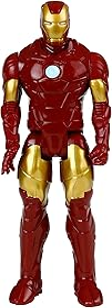

Using Faster mode: greedy (max_new_tokens=64, min_new_tokens=8)
Generated_ids shape: (1, 215)
TEXT_OUT IS
['Unleash the power of Iron Man with this 30.5 cm Hasbro Marvel Avengers Titan Hero Action Figure!  Perfect for fans of the Marvel Universe, this Iron Man figure is ready for action with a detailed design and classic colors.  A must-have for any action figure collection!']
total 8
4 drwxr-xr-x 2 root root 4096 Sep  5 00:50 ./
4 drwxr-xr-x 1 root root 4096 Sep  5 00:50 ../
amazon_adapter_20250905_013611_6ff78b


/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


messages
[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an expert product description writer for Amazon.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': 'https://m.media-amazon.com/images/I/81+7Up7IWyL._AC_SY300_SX300_.jpg'}, {'type': 'text', 'text': 'Create a Short Product description based on the provided ##PRODUCT NAME## and ##CATEGORY## and image.\nOnly return description. The description should be SEO optimized and for a better mobile search experience.\n\n##PRODUCT NAME##: Hasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur\n##CATEGORY##: Toys & Games | Toy Figures & Playsets | Action Figures'}]}]
inputs
{'input_ids': tensor([[151644,   8948,    198,   2610,    525,    458,   6203,   1985,   4008,
           6916,    369,   8176,     13, 151645,    198, 151644,    872,    198,
         151652, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 1

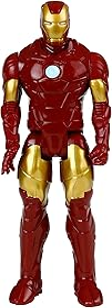

Using Faster mode: greedy (max_new_tokens=64, min_new_tokens=8)
Generated_ids shape: (1, 215)
TEXT_OUT IS
['Unleash the power of Iron Man with this 30.5 cm Hasbro Marvel Avengers Titan Hero Action Figure!  Perfect for fans of the Marvel Universe, this Iron Man figure is ready for action with a detailed design and classic colors.  A must-have for any action figure collection!']
Unleash the power of Iron Man with this 30.5 cm Hasbro Marvel Avengers Titan Hero Action Figure!  Perfect for fans of the Marvel Universe, this Iron Man figure is ready for action with a detailed design and classic colors.  A must-have for any action figure collection!


In [34]:
adapter_path = save_dir  # the folder you just listed
import shutil, pathlib
offload_dir = "/content/offload"
os.makedirs(offload_dir, exist_ok=True)

fineTuned_Model_result =  generate_description(sample, model, processor, inference_mode=mode_dd.value)

# Wipe contents if you want a clean cache
for p in pathlib.Path(offload_dir).glob("*"):
    if p.is_file():
        p.unlink()
    else:
        shutil.rmtree(p)

%ls -las  {offload_dir}

#create unique adapter_name
from datetime import datetime
import uuid
adapter_name = f"amazon_adapter_{datetime.now().strftime('%Y%m%d_%H%M%S')}_{uuid.uuid4().hex[:6]}"
print(adapter_name)


# Unload any existing adapter with the default name
from peft import PeftModel
if isinstance(model, PeftModel):
    try:
        model.unload()
    except ValueError:
        # No adapter with the default name was found, continue
        pass

model.load_adapter(adapter_path, adapter_name=adapter_name, offload_folder=offload_dir) # load the adapter and activate

#ft_description = generate_description(sample, model, processor)
fineTuned_Model_result =  generate_description(sample, model, processor, inference_mode=inference_mode)
print(fineTuned_Model_result)

## STEP 7.3 Compare
Lets compare them side by side using a markdown table.

In [36]:
print("ORIGINAL Model output")
print(output_result)
print("FINE-TUNED Model output")
print(fineTuned_Model_result)

ORIGINAL Model output
Introducing the Hasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur, a must-have addition to any superhero collection! This 30.5 cm tall Iron Man action figure is made of durable plastic and features a detailed design that captures the iconic
FINE-TUNED Model output
Unleash the power of Iron Man with this 30.5 cm Hasbro Marvel Avengers Titan Hero Action Figure!  Perfect for fans of the Marvel Universe, this Iron Man figure is ready for action with a detailed design and classic colors.  A must-have for any action figure collection!


In [37]:
import pandas as pd
from IPython.display import display, HTML

def compare_generations(base_gen, ft_gen):
    # Create a DataFrame
    df = pd.DataFrame({
        'Base Generation': [base_gen],
        'Fine-tuned Generation': [ft_gen]
    })
    # Style the DataFrame
    styled_df = df.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
        'border': '1px solid black',
        'padding': '10px',
        'width': '250px',  # Set width to 150px
        'overflow-wrap': 'break-word'  # Allow words to break and wrap as needed
    })

    # Display the styled DataFrame
    display(HTML(styled_df.to_html()))

compare_generations(output_result, fineTuned_Model_result)

,Base Generation,Fine-tuned Generation
0,"Introducing the Hasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur, a must-have addition to any superhero collection! This 30.5 cm tall Iron Man action figure is made of durable plastic and features a detailed design that captures the iconic","Unleash the power of Iron Man with this 30.5 cm Hasbro Marvel Avengers Titan Hero Action Figure! Perfect for fans of the Marvel Universe, this Iron Man figure is ready for action with a detailed design and classic colors. A must-have for any action figure collection!"


Nice! We just had ~1k samples & trained for (X=1) Epochs --does the  the fine-tuning improve the product description generation? The description is way shorter and more concise, which fits our training data.

# STEP 8 Optional: Merge LoRA adapter in to the original model

When using QLoRA, we only train adapters and not the full model. This means when saving the model during training we only save the adapter weights and not the full model. If you want to save the full model, which makes it easier to use with Text Generation Inference you can merge the adapter weights into the model weights using the `merge_and_unload` method and then save the model with the `save_pretrained` method. This will save a default model, which can be used for inference.

_Note: This requires > 30GB CPU Memory._

<font color=red> NOTE: this is not tested</font>

In [ ]:
from peft import PeftModel
from transformers import AutoProcessor, AutoModelForVision2Seq

adapter_path = "./qwen2-7b-instruct-amazon-description"
base_model_id = "Qwen/Qwen2-VL-7B-Instruct"
merged_path = "merged"

# Load Model base model
model = AutoModelForVision2Seq.from_pretrained(model_id, low_cpu_mem_usage=True)

# Path to save the merged model

# Merge LoRA and base model and save
peft_model = PeftModel.from_pretrained(model, adapter_path)
merged_model = peft_model.merge_and_unload()
merged_model.save_pretrained(merged_path,safe_serialization=True, max_shard_size="2GB")

processor = AutoProcessor.from_pretrained(base_model_id)
processor.save_pretrained(merged_path)

# STEP Bonus: Use TRL example script

TRL provides a simple example script to fine-tune multimodal models. You can find the script [here](https://github.com/huggingface/trl/blob/main/examples/scripts/sft_vlm.py). The script can be directly run from the command line and supports all the features of the `SFTTrainer`.
```bash
# Tested on 8x H100 GPUs
accelerate launch
    --config_file=examples/accelerate_configs/deepspeed_zero3.yaml \
    examples/scripts/sft_vlm.py \
    --dataset_name HuggingFaceH4/llava-instruct-mix-vsft \
    --model_name_or_path llava-hf/llava-1.5-7b-hf \
    --per_device_train_batch_size 8 \
    --gradient_accumulation_steps 8 \
    --output_dir sft-llava-1.5-7b-hf \
    --bf16 \
    --torch_dtype bfloat16 \
    --gradient_checkpointing
```